<a href="https://colab.research.google.com/github/phonghnguyen/Colab_NEXAFS/blob/main/TFSI_2_F_K_Edge_Quantum_ESPRESSO_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install `ase` for preparing input files, reading output files and visualization

In [ ]:
%%capture
!apt install ase
import ase

Some utilities that are used throughout this notebook:

In [ ]:
# Plot formatting
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_dirs = ['/content/drive/MyDrive/Fonts/']

font_files = font_manager.findSystemFonts(fontpaths = font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# font_names = [f.name for f in font_manager.fontManager.ttflist]
# print(font_names)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

# Artifact filtering from XSpectra files
import glob

def remove_artifact(file_name, target_energy=-0.10033445):
    with open(file_name, 'r') as f:
        lines = f.readlines()

    # Only keep lines that do not contain the artifact energy
    new_lines = [line for line in lines if not line.strip().startswith(str(target_energy))]

    # Write the modified data back into the file
    with open(file_name, 'w') as f:
        f.writelines(new_lines)

# Iterate over all '_xanes.dat' files
xanes_files = glob.glob('*_xanes.dat')
for file_name in xanes_files:
    remove_artifact(file_name)

In [ ]:
qe_relax_input_file = 'TFSI_2.relax.in'
qe_relax_output_file = 'TFSI_2.relax.out'

In [ ]:
qe_scf_input_file = 'TFSI_2.scf.in'
qe_scf_output_file = 'TFSI_2.scf.out'

In [ ]:
qe_xspectra_input_file = 'TFSI_2.xspectra.in'
qe_xspectra_output_file = 'TFSI_2.xspectra.out'

# Install the Quantum ESPRESSO Binary

In [ ]:
%%capture
# Clone the QE git
!git clone https://github.com/QEF/q-e.git
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
# enter the q-e folder
%cd q-e
# run the configure file
!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp

Run the cells to make `pw.x`, `xspectra.x`, and `ld1.x` executables

In [ ]:
%%capture
!make pw

In [ ]:

%%capture
!make xspectra

In [ ]:
%%capture
!make ld1

# Navigate to working directory

In [ ]:
%cd /content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2/

/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2


# 1. Structural relaxation

This approach is different for reduced F4TCNQ, which is a radical anion species. We set the total charge to be -1 and include spin polarization as the unpaired electron introduces it. As a first guess, we assume that the unpaired electron is distributed over the carbon atoms. We should expect that the resulting atomic arrange represents the quinoidal form.

Write the input file for structural relaxation calculations (note that the initial atomic positions are from Avagadro):

In [56]:
qe_input = """
&CONTROL
    calculation='relax',
    restart_mode='restart',
    prefix='TFSI_2',
    outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2/',
    pseudo_dir = '/content/drive/MyDrive/Quantum_ESPRESSO/SSSP_efficiency/',
    etot_conv_thr = 1e-5,
    forc_conv_thr = 1e-4,
    disk_io='medium'
/
&SYSTEM
    ibrav = 1,
    celldm(1) = 40,
    nat = 15,
    ntyp = 5,
    ecutwfc = 30,
    tot_charge = -1,
/
&ELECTRONS
    conv_thr =  1.0d-8
/
&IONS
/

ATOMIC_SPECIES
F 18.988 f_pbe_v1.4.uspp.F.UPF
N 14.007 N.pbe-n-radius_5.UPF
C 12.011 C.pbe-n-kjpaw_psl.1.0.0.UPF
S 32.065 s_pbe_v1.4.uspp.F.UPF
O 15.999 O.pbe-n-kjpaw_psl.0.1.UPF

ATOMIC_POSITIONS angstrom
S    11.7136472693   11.3000525590   10.2512506812
S     9.5503254009   10.3168940131   11.4566453285
F     8.4634392598   10.5198711973    8.9859226145
F     7.1207962546   11.0396283436   10.6118427876
F     8.6817974366   12.4404943620   10.0411900162
F    14.0020792833    9.9222117007   10.3085105838
F    12.2816506557    8.6879076197    9.8257328170
F    12.6227796852    9.3650132870   11.8933939782
O    11.0691251438   11.1511733007    8.9460568546
O    12.7051340012   12.3833522029   10.2706453749
O     9.8738450585    8.9753595859   10.9701011625
O     8.7870742908   10.2932778593   12.7111771460
N    10.7491969769   11.3526836720   11.5081815080
C    12.6710725072    9.7481251509   10.5847155344
C     8.4295513287   11.1104063064   10.2114367797

K_POINTS automatic
1 1 1 0 0 0
"""

# We write the input script
with open(qe_relax_input_file, "w") as f:
    f.write(qe_input)

Let's quickly check the input file to make sure our cell size is large enough to isolate individual molecules and that the molecule is centered in the cell.

In [ ]:
from ase import Atoms
from ase.io import read
import numpy as np

# Function to parse celldm(1) from QE input file
def get_celldm(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if 'celldm(1)' in line:
                return float(line.split('=')[1].split(',')[0])

# Read the atomic structure from the QE input file
atoms = read(qe_relax_input_file)

# Get the value of celldm(1)
celldm = get_celldm(qe_relax_input_file)

# Convert celldm(1) from Bohr radius (atomic units) to Angstrom
celldm_angstrom = celldm * 0.529177

# Print the dimensions of the box
print(f"The dimensions of the box are {celldm_angstrom} x {celldm_angstrom} x {celldm_angstrom} Angstrom.")

# Calculate the centroid of the molecule
centroid = atoms.get_center_of_mass()

# The center of the unit cell
center = [celldm_angstrom/2, celldm_angstrom/2, celldm_angstrom/2]

# Check if the molecule is already centered in the unit cell
if np.allclose(centroid, center):
    print("The atomic positions in the input file are already centered in the unit cell.")
else:
    print("The atomic positions in the input file are not centered in the unit cell.")
    print("Suggested modifications to the atomic positions to center them in the unit cell:")

    # Calculate the translation vector
    translation = np.subtract(center, centroid)

    # Translate the molecule to the center of the unit cell
    atoms.translate(translation)

    # Print the new atomic positions
    print("\nNew atomic positions (Angstrom):")
    for atom in atoms:
        print(f"{atom.symbol:2} {atom.position[0]:15.10f} {atom.position[1]:15.10f} {atom.position[2]:15.10f}")

# Check the distance between periodic images
min_dist_from_wall = np.min(atoms.positions)
distance_between_images = 2 * min_dist_from_wall

print(f"Distance between periodic images: {distance_between_images} Angstroms.")

if distance_between_images < 10 or distance_between_images > 15:
    print("Warning: The distance between periodic images is outside the ideal range (10-15 Angstroms).")
    suggested_celldm = (min_dist_from_wall + 5)*2
    print(f"Suggested celldm(1) to maintain a distance of 10-15 Angstroms between periodic images: {suggested_celldm/0.529177}")

The dimensions of the box are 21.16708 x 21.16708 x 21.16708 Angstrom.
The atomic positions in the input file are already centered in the unit cell.
Distance between periodic images: 14.2415925092 Angstroms.


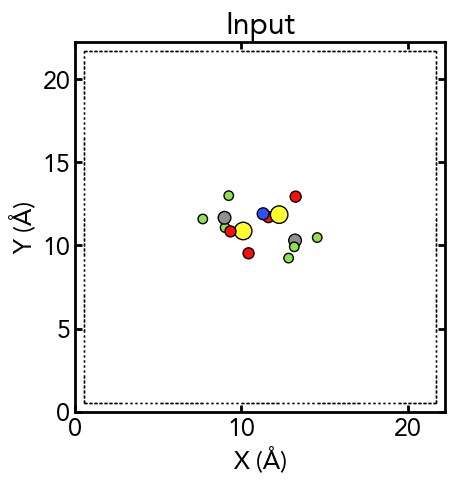

In [ ]:
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.visualize.plot import animate

# Read the atomic structure from the Quantum_ESPRESSO input file
atoms = read(qe_relax_input_file)

# Center the view on the molecule
atoms.center()

# Plot the atoms
fig, ax = plt.subplots()
plot_atoms(atoms, ax=ax, radii = 0.5, rotation=('0x,0y,0z'))

# Add axis labels
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_title('Input')
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

# Show the plot
plt.show()

If we're happy, we can run the computation to relax the structure.

In [ ]:
! /content/q-e/bin/pw.x  -in TFSI.relax.in > TFSI.relax.out

ASE is not able to visualize the structure from calculations that consider magnetization and spin polarization. You will need to manually check and ensure that calculations moving forward use the coordinates from the relaxation output file.

# 2 + 3. Self-consistent field (SCF) and XSpectra calculation

To improve accuracy, we need core-hole pseudopotentials. To do this, we will take an existing, established pseudopotential, parse the input used to generate it, and modify it to have a core hole. Specifically, remove an electron from the 1s core level, turning it from a 1s^2 configuration to a 1s^1 configuration. An example is shown at this link: https://indico.ictp.it/event/a11191/session/17/contribution/9/material/0/0.pdf. If we use the `C.pbe-n-kjpaw_psl.1.0.0.UPF` pseudopotential file from the SSSP efficiency library as a basis, the input used to generate it was:

```
 &input
   title='C',
   zed=6.,
   rel=1,
   config='[He] 2s2 2p2',
   iswitch=3,
   dft='PBE'
 /
 &inputp
   lpaw=.true.,
   pseudotype=3,
   file_pseudopw='C.pbe-n-kjpaw_psl.1.0.0.UPF',
   author='ADC',
   lloc=-1,
   rcloc=0.9
   which_augfun='PSQ',
   rmatch_augfun_nc=.true.,
   nlcc=.true.,
   new_core_ps=.true.,
   rcore=0.7,
   tm=.true.
 /
4
2S  1  0  2.00  0.00  1.00  1.20  0.0
2S  1  0  0.00  3.00  1.00  1.20  0.0
2P  2  1  2.00  0.00  0.90  1.40  0.0
2P  2  1  0.00  0.05  0.90  1.40  0.0
```

The corresponding core hole pseudopotential file can be generated using the following modified input:



```
qe_ld1_input_file = 'C_corehole.in'
qe_ld1_output_file = 'C_corehole.out'
```



```
qe_input = """
 &input
   title='C_corehole',
   zed=6.,
   rel=1,
   config='1s1 2s2 2p2',
   iswitch=3,
   dft='PBE'
 /
 &inputp
   lpaw=.true.,
   pseudotype=3,
   file_pseudopw='C_corehole.pbe-n-kjpaw_psl.1.0.0.UPF',
   author='anonymous',
   lloc=-1,
   rcloc=0.9,
   which_augfun='PSQ',
   rmatch_augfun_nc=.true.,
   nlcc=.true.,
   new_core_ps=.true.,
   rcore=0.7,
   tm=.true.,
   lgipaw_reconstruction=.true.,
 /
4
2S  1  0  2.00  0.00  1.00  1.20  0.0
2S  1  0  0.00  3.00  1.00  1.20  0.0
2P  2  1  2.00  0.00  0.90  1.40  0.0
2P  2  1  0.00  0.05  0.90  1.40  0.0
"""

# We write the input script
with open(qe_ld1_input_file, "w") as f:
    f.write(qe_input)
```

The core hole pseudopotential file can now be generated using `ld1.x`.

```
! /content/q-e/bin/ld1.x  -in C_corehole.in > C_corehole.out
```

In [ ]:
qe_ld1_input_file = 'C_corehole.in'
qe_ld1_output_file = 'C_corehole.out'

In [ ]:
qe_input = """
 &input
   title='C_corehole',
   zed=6.,
   rel=1,
   config='1s1 2s2 2p2',
   iswitch=3,
   dft='PBE'
 /
 &inputp
   lpaw=.true.,
   pseudotype=3,
   file_pseudopw='C_corehole.pbe-n-kjpaw_psl.1.0.0.UPF',
   author='anonymous',
   lloc=-1,
   rcloc=0.9,
   which_augfun='PSQ',
   rmatch_augfun_nc=.true.,
   nlcc=.true.,
   new_core_ps=.true.,
   rcore=0.7,
   tm=.true.,
   lgipaw_reconstruction=.true.,
 /
4
2S  1  0  2.00  0.00  1.00  1.20  0.0
2S  1  0  0.00  3.00  1.00  1.20  0.0
2P  2  1  2.00  0.00  0.90  1.40  0.0
2P  2  1  0.00  0.05  0.90  1.40  0.0
"""

# We write the input script
with open(qe_ld1_input_file, "w") as f:
    f.write(qe_input)

Let's generate the core hole pseudopotential file.

In [ ]:
! /content/q-e/bin/ld1.x  -in C_corehole.in > C_corehole.out

In previous notebooks, we have walked through the single atom NEXAFS simulations, first running the SCF calculation, followed by the XSpectra calculation for the x-, y-, and z-polarized X-rays. Here, we implement it for a molcule.

The code will iterate over each atom, writing the SCF input files in such a way that every iteration simulates the contributions of the specific atom to the spectra.

The format we use to specify atom type and position is the same as that used by Quantum ESPRESSO. Specifically, we will use the relaxed atomic coordinates and denote the atoms over which we want to iterate by adding an asterisk (*) before that atom.

In this particular example, the code will perform the SCF and XSpectra calculations for the four carbon atoms (*) I've highlighted. To help users visualize their input, we've also included a feature that marks the atoms contributing to the NEXAFS spectra in red on the graphical representation of the molecule.

We first need to make sure there is a suitable SCF input file that serves as the basis the remaining calculations.

In [57]:
qe_input = """
&CONTROL
calculation='scf',
prefix='TFSI_2',
outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2/',
pseudo_dir = '/content/drive/MyDrive/Quantum_ESPRESSO/Pseudopotentials/',
/
&SYSTEM
ibrav = 1,
celldm(1) = 40,
nat = 15,
ntyp = 6,
ecutwfc=40,
occupations='smearing',
smearing='fd',
degauss=0.0019,
tot_charge = -1,
/
&ELECTRONS
mixing_beta=0.3,
/

ATOMIC_SPECIES
F_h 18.988 F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF
F 18.988 F.pbe-n-kjpaw_psl.1.0.0.UPF
N 14.007 N.pbe-n-radius_5.UPF
C 12.011 C.pbe-n-kjpaw_psl.1.0.0.UPF
S 32.065 S.pbe-n-kjpaw_psl.1.0.0.UPF
O 15.999 O.pbe-n-kjpaw_psl.0.1.UPF

ATOMIC_POSITIONS angstrom
S    11.7136472693   11.3000525590   10.2512506812
S     9.5503254009   10.3168940131   11.4566453285
F     8.4634392598   10.5198711973    8.9859226145
F     7.1207962546   11.0396283436   10.6118427876
F     8.6817974366   12.4404943620   10.0411900162
F    14.0020792833    9.9222117007   10.3085105838
F    12.2816506557    8.6879076197    9.8257328170
F    12.6227796852    9.3650132870   11.8933939782
O    11.0691251438   11.1511733007    8.9460568546
O    12.7051340012   12.3833522029   10.2706453749
O     9.8738450585    8.9753595859   10.9701011625
O     8.7870742908   10.2932778593   12.7111771460
N    10.7491969769   11.3526836720   11.5081815080
C    12.6710725072    9.7481251509   10.5847155344
C     8.4295513287   11.1104063064   10.2114367797

K_POINTS automatic
1 1 1 0 0 0
"""

# We write the input script
with open(qe_scf_input_file, "w") as f:
    f.write(qe_input)

In [ ]:
! /content/q-e/bin/pw.x  -in TFSI_2.scf.in > TFSI_2.scf.out

^C


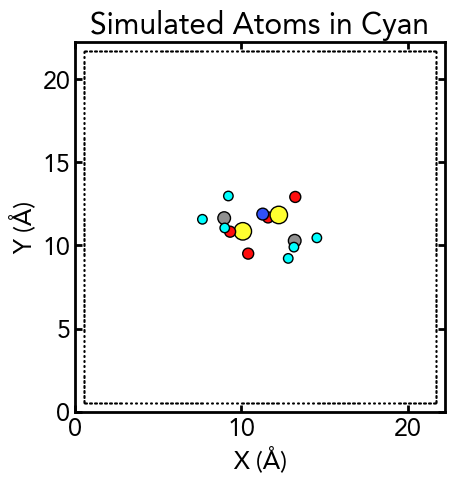

In [ ]:
from ase.io import read
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase import Atoms

# User provides the atom types and positions in the form of a string
atoms_string = """
S    11.7136472693   11.3000525590   10.2512506812
S     9.5503254009   10.3168940131   11.4566453285
*F     8.4634392598   10.5198711973    8.9859226145
*F     7.1207962546   11.0396283436   10.6118427876
*F     8.6817974366   12.4404943620   10.0411900162
*F    14.0020792833    9.9222117007   10.3085105838
*F    12.2816506557    8.6879076197    9.8257328170
*F    12.6227796852    9.3650132870   11.8933939782
O    11.0691251438   11.1511733007    8.9460568546
O    12.7051340012   12.3833522029   10.2706453749
O     9.8738450585    8.9753595859   10.9701011625
O     8.7870742908   10.2932778593   12.7111771460
N    10.7491969769   11.3526836720   11.5081815080
C    12.6710725072    9.7481251509   10.5847155344
C     8.4295513287   11.1104063064   10.2114367797
"""

# Read atomic positions
atoms = read(qe_scf_input_file)

# Parse the atoms string to create a list of atoms and a list of indices for excited atoms
atom_info = atoms_string.strip().split('\n')
excited_atoms_info = [atom for atom in atom_info if '*' in atom]
normal_atoms_info = [atom for atom in atom_info if '*' not in atom]

excited_atoms_info = [atom.replace('*', '') for atom in excited_atoms_info]  # Remove asterisks from excited atoms

def parse_info(info_list):
    atom_positions = []
    atom_types = []
    for atom in info_list:
        elements = atom.split()
        atom_type, x, y, z = elements[0], float(elements[1]), float(elements[2]), float(elements[3])
        atom_positions.append([x, y, z])
        atom_types.append(atom_type)
    return atom_types, atom_positions

normal_atom_types, normal_atom_positions = parse_info(normal_atoms_info)
excited_atom_types, excited_atom_positions = parse_info(excited_atoms_info)

# Create an Atoms object for the normal and excited atoms
atoms_normal = Atoms(symbols=normal_atom_types, positions=normal_atom_positions)
atoms_excited = Atoms(symbols=excited_atom_types, positions=excited_atom_positions)

# Use the same cell for both
atoms_normal.set_cell(atoms.get_cell())
atoms_excited.set_cell(atoms.get_cell())

# Create subplots
fig, ax = plt.subplots()

# Plot the atoms
plot_atoms(atoms_normal, ax=ax, radii=0.5, rotation=('0x,0y,0z'))

# Plot the excited atoms with a different color
plot_atoms(atoms_excited, ax=ax, radii=0.5, rotation=('0x,0y,0z'), colors=['#00FFFF']*len(atoms_excited))

# Add axis labels
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_title('Simulated Atoms in Cyan')
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

plt.show()

Let's make sure that we are using the correct work function for these series of atoms.

In [ ]:
! /content/q-e/XSpectra/tools/upf2plotcore.sh /content/drive/MyDrive/Quantum_ESPRESSO/Pseudopotentials/F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF > current_wfc.wfc

The cell below will iterate over all atoms specified and generate unique filenames for the `_xanes.dat` files. You should double-check to make sure that file names and directories are appropriate.

In [ ]:
# Parse the atoms string to create a list of atoms and a list of indices for excited atoms
atom_positions = [atom.split() for atom in atoms_string.strip().split('\n')]
excited_atoms_indices = [i for i, atom in enumerate(atom_positions) if '*' in atom[0]]
atom_positions = [[atom_type.replace('*', ''), *coordinates] for atom_type, *coordinates in atom_positions]  # Remove asterisks from all atoms

# Iterate over each excited atom
for i in excited_atoms_indices:
    # Make a fresh copy of the atom positions, removing any _h suffix
    new_atom_positions = [[atom_type.replace('_h', ''), *coordinates] for atom_type, *coordinates in atom_positions.copy()]
    new_atom_positions[i][0] += "_h"  # Add _h suffix to the current atom

    # Format the atomic positions for the SCF input file
    formatted_positions = "\n".join(" ".join(map(str, pos)) if i == 0 else "    " + " ".join(map(str, pos)) for i, pos in enumerate(new_atom_positions))

    # Write the Quantum Espresso SCF input file
    qe_input = """
    &CONTROL
    calculation='scf',
    prefix='TFSI_2',
    outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2/',
    pseudo_dir = '/content/drive/MyDrive/Quantum_ESPRESSO/Pseudopotentials/',
    /
    &SYSTEM
    ibrav = 1,
    celldm(1) = 40,
    nat = 15,
    ntyp = 6,
    ecutwfc=40,
    occupations='smearing',
    smearing='fd',
    degauss=0.0019,
    tot_charge = -1,
    /
    &ELECTRONS
    mixing_beta=0.3,
    /

    ATOMIC_SPECIES
    F_h 18.988 F_corehole.pbe-n-kjpaw_psl.1.0.0.UPF
    F 18.988 F.pbe-n-kjpaw_psl.1.0.0.UPF
    N 14.007 N.pbe-n-radius_5.UPF
    C 12.011 C.pbe-n-kjpaw_psl.1.0.0.UPF
    S 32.065 S.pbe-n-kjpaw_psl.1.0.0.UPF
    O 15.999 O.pbe-n-kjpaw_psl.0.1.UPF

    ATOMIC_POSITIONS angstrom
    """ + ''.join(formatted_positions) + """

    K_POINTS {automatic}
        1 1 1 0 0 0
    """

    with open(f'TFSI_2.scf.in', 'w') as file:
        file.write(qe_input)

    # Run the SCF calculation
    ! /content/q-e/bin/pw.x  -in TFSI_2.scf.in > TFSI_2.scf.out

    # Define the desired values for xkvec and xepsilon
    values = [((0, 1, 0), (1, 0, 0)),
              ((0, 0, 1), (0, 1, 0)),
              ((1, 0, 0), (0, 0, 1))]

    # Initialize the lists
    xanes_files = []

    # Generate the file names and input files
    for xkvec, xepsilon in values:
        # Generate the file name based on the xkvec and xepsilon values
        xanes_file = f'TFSI_2_F_{i}_xkvec{"%i%i%i" % xkvec}_xepsilon{"%i%i%i" % xepsilon}_xanes.dat'
        xanes_files.append(xanes_file)

        qe_input = f"""
        &input_xspectra
            calculation='xanes_dipole'
            prefix='TFSI_2',
            outdir='/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2/',
            xniter=1000,
            xcheck_conv=50,
            xkvec(1)={xkvec[0]},
            xkvec(2)={xkvec[1]},
            xkvec(3)={xkvec[2]},
            xepsilon(1)={xepsilon[0]},
            xepsilon(2)={xepsilon[1]},
            xepsilon(3)={xepsilon[2]},
            xiabs=1,
            x_save_file='TFSI_2.xspectra.sav',
            xerror=0.001
        /
        &plot
            xnepoint=300,
            xemin=-10.0,
            xemax=30.0,
            terminator=.true.,
            cut_occ_states=.true.,
            xanes_file='{xanes_file}',
            xgamma=0.8
        /
        &pseudos
            filecore='current_wfc.wfc',
        /
        &cut_occ
        /
        1 1 1 0 0 0
        """

        # We write the input script
        with open(qe_xspectra_input_file, "w") as f:
            f.write(qe_input)

        # Run XSpectra
        ! /content/q-e/bin/xspectra.x  -in TFSI_2.xspectra.in > TFSI_2.xspectra.out

The code below filters an artifact from the calculations:

In [44]:
# Iterate over all '_xanes.dat' files
xanes_files = glob.glob('*_xanes.dat')
for file_name in xanes_files:
    remove_artifact(file_name)

The cell below searches for the output files from the simulations run above and sums them over all atoms to generate the molecular NEXAFS we are after.

In [47]:
import glob

# Define the patterns for the files
patterns = ['TFSI_2_F_*xepsilon100_xanes.dat',
            'TFSI_2_F_*xepsilon010_xanes.dat',
            'TFSI_2_F_*xepsilon001_xanes.dat']

output_files = ['TFSI_2_F_Kedge_xepsilon100_xanes.dat',
                'TFSI_2_F_Kedge_xepsilon010_xanes.dat',
                'TFSI_2_F_Kedge_xepsilon001_xanes.dat']

# Iterate over each pattern
for pattern, output_file in zip(patterns, output_files):
    # Get a list of all matching files
    matching_files = glob.glob(pattern)

    # Initialize lists for the energy and sigma
    total_energy = []
    total_sigma = []

    # Initialize variable for the headers
    headers = []

    # Iterate over each matching file
    for i, file_name in enumerate(matching_files):
        # Initialize empty lists for energy and sigma
        energy = []
        sigma = []

        # Read file
        with open(file_name, 'r') as file:
            for line in file:
                # If it's a header line and we're in the first file, save it
                if line[0] == '#' and i == 0:
                    headers.append(line)
                    continue

                # Skip any other header lines
                elif line[0] == '#':
                    continue

                # Split the line into energy and sigma
                e, s = line.split()
                # Append to lists
                energy.append(float(e))
                sigma.append(float(s))

        # If total_energy and total_sigma is empty, set them to energy and sigma, otherwise add energy and sigma to them
        if not total_energy and not total_sigma:
            total_energy = energy
            total_sigma = sigma
        else:
            total_sigma = [sum(x) for x in zip(total_sigma, sigma)]

    # Save the total energy and sigma to a new file
    with open(output_file, 'w') as f:
        # Write the headers
        for header in headers:
            f.write(header)
        # Write the data
        for e, s in zip(total_energy, total_sigma):
            f.write(f'{e}    {s}\n')

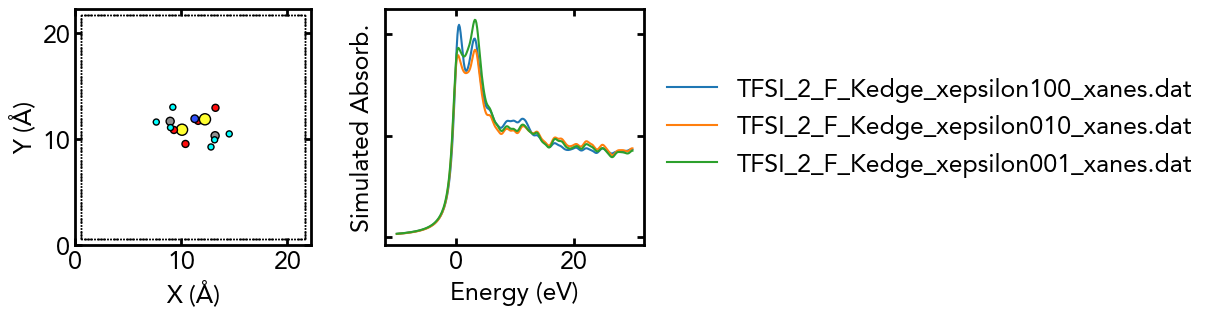

In [59]:
from ase import Atoms
from ase.io import read
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.visualize.plot import animate
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import glob

# Get a list of all '_xanes.dat' files
xanes_files = glob.glob('TFSI_2_F_Kedge_*_xanes.dat')

# User provides the atom types and positions in the form of a string
atoms_string = """
S    11.7136472693   11.3000525590   10.2512506812
S     9.5503254009   10.3168940131   11.4566453285
*F     8.4634392598   10.5198711973    8.9859226145
*F     7.1207962546   11.0396283436   10.6118427876
*F     8.6817974366   12.4404943620   10.0411900162
*F    14.0020792833    9.9222117007   10.3085105838
*F    12.2816506557    8.6879076197    9.8257328170
*F    12.6227796852    9.3650132870   11.8933939782
O    11.0691251438   11.1511733007    8.9460568546
O    12.7051340012   12.3833522029   10.2706453749
O     9.8738450585    8.9753595859   10.9701011625
O     8.7870742908   10.2932778593   12.7111771460
N    10.7491969769   11.3526836720   11.5081815080
C    12.6710725072    9.7481251509   10.5847155344
C     8.4295513287   11.1104063064   10.2114367797
"""
# Read atomic positions
atoms = read(qe_scf_input_file)

# Parse the atoms string to create a list of atoms and a list of indices for excited atoms
atom_info = atoms_string.strip().split('\n')
excited_atoms_info = [atom for atom in atom_info if '*' in atom]
normal_atoms_info = [atom for atom in atom_info if '*' not in atom]

excited_atoms_info = [atom.replace('*', '') for atom in excited_atoms_info]  # Remove asterisks from excited atoms

def parse_info(info_list):
    atom_positions = []
    atom_types = []
    for atom in info_list:
        elements = atom.split()
        atom_type, x, y, z = elements[0], float(elements[1]), float(elements[2]), float(elements[3])
        atom_positions.append([x, y, z])
        atom_types.append(atom_type)
    return atom_types, atom_positions

normal_atom_types, normal_atom_positions = parse_info(normal_atoms_info)
excited_atom_types, excited_atom_positions = parse_info(excited_atoms_info)

# Create an Atoms object for the normal and excited atoms
atoms_normal = Atoms(symbols=normal_atom_types, positions=normal_atom_positions)
atoms_excited = Atoms(symbols=excited_atom_types, positions=excited_atom_positions)

# Use the same cell for both
atoms_normal.set_cell(atoms.get_cell())
atoms_excited.set_cell(atoms.get_cell())

# Create subplots
fig, axs = plt.subplots(1,2, figsize = (7, 3.5))

# Plot the atoms
plot_atoms(atoms_normal, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'))

# Plot the excited atoms with a different color
plot_atoms(atoms_excited, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'), colors=['#00FFFF']*len(atoms_excited))

# Add axis labels
axs[0].set_xlabel('X (Å)')
axs[0].set_ylabel('Y (Å)')
axs[0].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[0].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

# Iterate over all '_xanes.dat' files
for file_name in xanes_files:
    # Initialize empty lists for energy and sigma
    energy = []
    sigma = []

    # Read file
    with open(file_name, 'r') as file:
        for line in file:
            # Skip lines that start with '#'
            if line[0] != '#':
                # Split the line into energy and sigma
                e, s = line.split()
                # Append to lists
                energy.append(float(e))
                sigma.append(float(s))

    # Plot the spectra
    axs[1].plot(energy, sigma, label=file_name)

# Add axis labels
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel(r'Simulated Absorb.')
axs[1].set_yticklabels([])
axs[1].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[1].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

plt.tight_layout()

# Add legend to the right of the second plot
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Show the plot
plt.show()

# Save the figure
# fig.savefig('/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_10/F4TCNQ/F4TCNQ_F_Kedge.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

In Near Edge X-ray Absorption Fine Structure (NEXAFS) spectroscopy, the observed spectra can be significantly influenced by the orientation of the molecule relative to the incident X-ray's polarization. This can be explored by setting a fixed direction for the polarization and accordingly rotating the molecule. In this way, the NEXAFS signal can be interpreted as a vector component-weighted sum of contributions from the x-, y-, and z-polarized NEXAFS.

The code example provided below simulates this scenario. We set the polarization direction along the x-axis (termed the "polarization axis", although it represents a real spatial direction) and rotate the molecule to match. The y-axis, orthogonal to the polarization direction, is labeled the "X-ray wave vector axis". In this approximation, we assume that the direction from which the X-ray is propagated (i.e., the direction of the wave vector) does not influence the NEXAFS, an assumption that is reasonable for many systems.

This method provides an understanding of how NEXAFS varies with molecular orientation, which can be crucial for interpreting experimental results.

There are several observations to note from the above example. Firstly, for each X-ray polarization (xepsilon) aligned with the x-, y-, and z-axis, there are two orthogonal X-ray wave vectors (xkvec). We've simulated all six possible pairs, but due to overlap, only three curves are visible. This indicates that in this simulation, the X-ray polarization vector is the primary factor; thus, we can simplify future simulations to include just the x-, y-, and z-polarized NEXAFS, with any arbitrary orthogonal X-ray wave vector.

Secondly, we've highlighted the fluorine atom (in red), whose NEXAFS we're simulating. All fluorine atoms in this molecule are identical, making it a representative choice for simulating the entire molecule's NEXAFS.

Lastly, we acknowledge that the molecular bonding does not intuitively suggest whether we would anticipate a transition dipole moment from fluorine. However, because DFT can simulate the electron density delocalized over the molecule, and the excited electron is likely to populate the lowest energy excited state, the delocalization significantly influences the anisotropy in the NEXAFS. In the dipole approximation (often a suitable approximation for NEXAFS experiments), the transition probability is proportional to the square of the dot product of the transition dipole moment and the X-ray's electric field vector. Hence, transitions are most probable when the transition dipole moment aligns with the X-ray's polarization, and least probable when they are orthogonal.

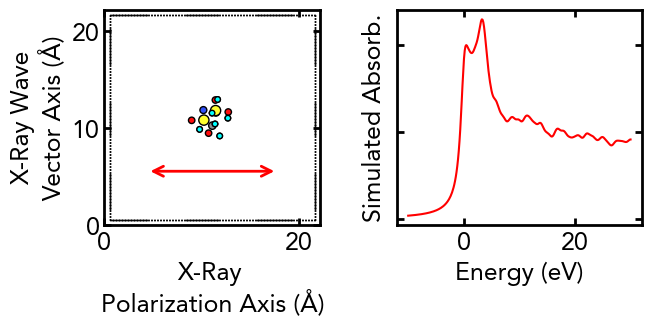

In [70]:
from scipy.spatial.transform import Rotation as R
import glob
import matplotlib.pyplot as plt
import ase.visualize.plot as ase_plot
from ase.visualize.plot import plot_atoms
from ase import Atoms
import numpy as np
from ase.io import read

# Function to rotate atomic positions
def rotate_positions(atoms, rotation, center):
    rotated_atomic_positions = []
    for atom in atoms:
        position = atom.position - center
        rotated_position = rotation.apply([position])[0]
        rotated_atomic_positions.append((atom.symbol, *(rotated_position + center)))
    return rotated_atomic_positions

# Specify the user-defined weights for the x-, y-, and z-polarized contributions
weights = [0, 0, 1]  # example weights

# User provides the atom types and positions in the form of a string
atoms_string = """
S    11.7136472693   11.3000525590   10.2512506812
S     9.5503254009   10.3168940131   11.4566453285
*F     8.4634392598   10.5198711973    8.9859226145
*F     7.1207962546   11.0396283436   10.6118427876
*F     8.6817974366   12.4404943620   10.0411900162
*F    14.0020792833    9.9222117007   10.3085105838
*F    12.2816506557    8.6879076197    9.8257328170
*F    12.6227796852    9.3650132870   11.8933939782
O    11.0691251438   11.1511733007    8.9460568546
O    12.7051340012   12.3833522029   10.2706453749
O     9.8738450585    8.9753595859   10.9701011625
O     8.7870742908   10.2932778593   12.7111771460
N    10.7491969769   11.3526836720   11.5081815080
C    12.6710725072    9.7481251509   10.5847155344
C     8.4295513287   11.1104063064   10.2114367797
"""

# Check if the weights sum to 1
if not np.isclose(sum(weights), 1):
    # If they don't, normalize the weights and print a warning
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    print("Warning: The weights did not sum to 1 and have been normalized.")

# Check if the weights are isotropic
isotropic = np.allclose(weights, [1/3, 1/3, 1/3])

if isotropic:
    print("The weights are isotropic. The molecule is randomly oriented and no rotation is applied.")

# Get a list of all '_xanes.dat' files
xanes_files_100 = glob.glob('TFSI_2_F_*100_xanes.dat')
xanes_files_010 = glob.glob('TFSI_2_F_*010_xanes.dat')
xanes_files_001 = glob.glob('TFSI_2_F_*001_xanes.dat')

# Lists of files
xanes_files_lists = [xanes_files_100, xanes_files_010, xanes_files_001]

# Initialize lists to store the energy and sigma values for each file
energy_values = []
sigma_values = []

# Iterate over the lists of files
for xanes_files in xanes_files_lists:
    # Initialize lists to store the energy and sigma values for the current list of files
    energy_list = []
    sigma_list = []

    # Iterate over the files in the current list
    for xanes_file in xanes_files:
        # Initialize empty lists for energy and sigma
        energy = []
        sigma = []

        # Read file
        with open(xanes_file, 'r') as file:
            for line in file:
                # Skip lines that start with '#'
                if line[0] != '#':
                    # Split the line into energy and sigma
                    e, s = line.split()
                    # Append to lists
                    energy.append(float(e))
                    sigma.append(float(s))

        # Add the energy and sigma values to their respective lists
        energy_list.append(energy)
        sigma_list.append(sigma)

    # Add the average energy and sigma values to their respective lists
    energy_values.append(np.mean(energy_list, axis=0))
    sigma_values.append(np.mean(sigma_list, axis=0))

# Calculate the weighted sum of the sigma values
weighted_sigma_sum = sum(w * s for w, s in zip(weights, sigma_values))

# Read atomic positions
atoms = read(qe_scf_input_file)

# Calculate the center of the molecule
center = atoms.get_center_of_mass()

# Calculate the net polarization direction
net_polarization = np.array(weights)

# Calculate the angle and rotation axis
angle = np.arccos(np.dot(net_polarization, [1, 0, 0]))
axis = np.cross([1, 0, 0], net_polarization)
rotation_vector = axis * angle

# If the net polarization
# Continue the code
rotation = None
if not np.allclose(net_polarization, [1, 0, 0]) and not isotropic:
    rotation = R.from_rotvec(rotation_vector)

# Read the atomic positions and apply rotation if necessary
rotated_atomic_positions = rotate_positions(atoms, rotation, center) if rotation else [(atom.symbol, *atom.position) for atom in atoms]

# Create an Atoms object for the rotated atoms
atoms_rotated = Atoms([atom_symbol for atom_symbol, _, _, _ in rotated_atomic_positions],
                      positions=[pos for _, *pos in rotated_atomic_positions])
atoms_rotated.set_cell(atoms.get_cell())

# Parse the atoms string to create a list of atoms and a list of indices for excited atoms
atom_info = atoms_string.strip().split('\n')
excited_atoms_info = [atom for atom in atom_info if '*' in atom]
normal_atoms_info = [atom for atom in atom_info if '*' not in atom]

excited_atoms_info = [atom.replace('*', '') for atom in excited_atoms_info]  # Remove asterisks from excited atoms

def parse_info(info_list):
    atom_positions = []
    atom_types = []
    for atom in info_list:
        elements = atom.split()
        atom_type, x, y, z = elements[0], float(elements[1]), float(elements[2]), float(elements[3])
        atom_positions.append([x, y, z])
        atom_types.append(atom_type)
    return atom_types, atom_positions

normal_atom_types, normal_atom_positions = parse_info(normal_atoms_info)
excited_atom_types, excited_atom_positions = parse_info(excited_atoms_info)

# Create an Atoms object for the normal and excited atoms
atoms_normal = Atoms(symbols=normal_atom_types, positions=normal_atom_positions)
atoms_excited = Atoms(symbols=excited_atom_types, positions=excited_atom_positions)

# Use the same cell for both
atoms_normal.set_cell(atoms.get_cell())
atoms_excited.set_cell(atoms.get_cell())

# Apply rotation to the excited atoms if necessary
rotated_excited_positions = rotate_positions(atoms_excited, rotation, center) if rotation else [(atom.symbol, *atom.position) for atom in atoms_excited]

# Create an Atoms object for the rotated excited atoms
atoms_excited_rotated = Atoms([atom for atom, _, _, _ in rotated_excited_positions],
                               positions=[pos for _, *pos in rotated_excited_positions])
atoms_excited_rotated.set_cell(atoms_excited.get_cell())

# Create subplots
fig, axs = plt.subplots(1,2, figsize = (7, 3.5))

# Plot the rotated atoms
ase_plot.plot_atoms(atoms_rotated, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'))

# Plot the rotated excited atoms with a different color
plot_atoms(atoms_excited_rotated, ax=axs[0], radii=0.5, rotation=('0x,0y,0z'), colors=['#00FFFF']*len(atoms_excited_rotated))

# Plot the resulting weighted sum
axs[1].plot(energy_values[0], weighted_sigma_sum, label='Weighted Sum \n(Randomly Oriented)' if isotropic else 'Weighted Sum', color='red', linewidth=1.5)

# Add axis labels
axs[0].set_xlabel('X-Ray \nPolarization Axis (Å)')
axs[0].set_ylabel('X-Ray Wave\nVector Axis (Å)')
axs[0].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[0].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel(r'Simulated Absorb.')
axs[1].set_yticklabels([])
axs[1].xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
axs[1].yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

# First, find the extent of the x-axis to place the arrow appropriately.
x_min, x_max = axs[0].get_xlim()

# Calculate the y position for the arrow. This places the arrow 2 Angstroms below the center of mass of the molecule.
arrow_y_position = atoms.get_center_of_mass()[1] - 5

# Calculate the start and end x positions for the arrow. This places the arrow 10% away from the edges of the plot.
arrow_x_start = x_min + 0.2 * (x_max - x_min)
arrow_x_end = x_max - 0.2 * (x_max - x_min)

if isotropic:
    # If the weights are isotropic, print the text instead of the arrow.
    axs[0].text(x_min + 0.5 * (x_max - x_min), arrow_y_position, "Isotropic Polarization", horizontalalignment='center', verticalalignment='center', fontsize=10, color='red')
else:
    # Draw a double-headed arrow to represent the polarization direction.
    axs[0].annotate("", xy=(arrow_x_end, arrow_y_position), xytext=(arrow_x_start, arrow_y_position),
                    arrowprops=dict(arrowstyle="<->", lw=2, color='red'))

plt.tight_layout()

# Add legend to the right of the second plot
# axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()

fig.savefig('/content/drive/MyDrive/Quantum_ESPRESSO/2023_06_20/TFSI_2/TFSI_2_F_Kedge_weighted_sum.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)